In [3]:
import numpy as np
import pandas as pd
import math
import missingno as mso
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')
import os
import matplotlib as mpl



In [4]:
df_kiva_loans = pd.read_csv("kiva_loans.csv")
df_mpi = pd.read_csv("kiva_mpi_region_locations.csv")

df_kiva_loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:51:08+00:00,2013-12-17 08:00:00+00:00,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,334.0,2014-01-01 09:58:07+00:00,2013-12-17 08:00:00+00:00,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 08:03:11+00:00,2013-12-24 08:00:00+00:00,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,245.0,2014-01-01 11:53:19+00:00,2013-12-17 08:00:00+00:00,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01


In [5]:
df_mpi.head()

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


In [5]:
df_mpi_gr = df_mpi.groupby(['ISO','country','world_region'])['MPI'].mean().fillna(0).reset_index()

df_kiva_loans = df_kiva_loans.merge(df_mpi_gr, how ='left', on='country')

df_kiva_loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,ISO,world_region,MPI
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,...,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01,PAK,South Asia,0.233167
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,...,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01,PAK,South Asia,0.233167
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,...,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01,IND,South Asia,0.000000
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,...,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01,PAK,South Asia,0.233167
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,...,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01,PAK,South Asia,0.233167


In [6]:
df_kiva_loans['borrower_genders'] = [i if i in ['female', 'male'] else 'group' for i in df_kiva_loans['borrower_genders'] ]


In [7]:
dtf_dpnd = df_kiva_loans.groupby(['borrower_genders','world_region', 'sector'])['sector'].count()\
.groupby(level=0).apply(lambda x: 100*x/x.sum()).unstack('borrower_genders').fillna(0).sort_values(by=['female','male'])[-20:]


dtf_dpnd = dtf_dpnd[['male','female','group']]
dtf_dpnd.head()




borrower_genders                          male    female     group
world_region                sector                                
South Asia                  Food      0.096784  1.167501  0.744796
East Asia and the Pacific   Services  0.884879  1.196914  0.141155
Latin America and Caribbean Services  2.607974  1.259611  1.075306
                            Clothing  0.667116  1.450797  2.289472
                            Housing   3.284596  1.471180  0.286901

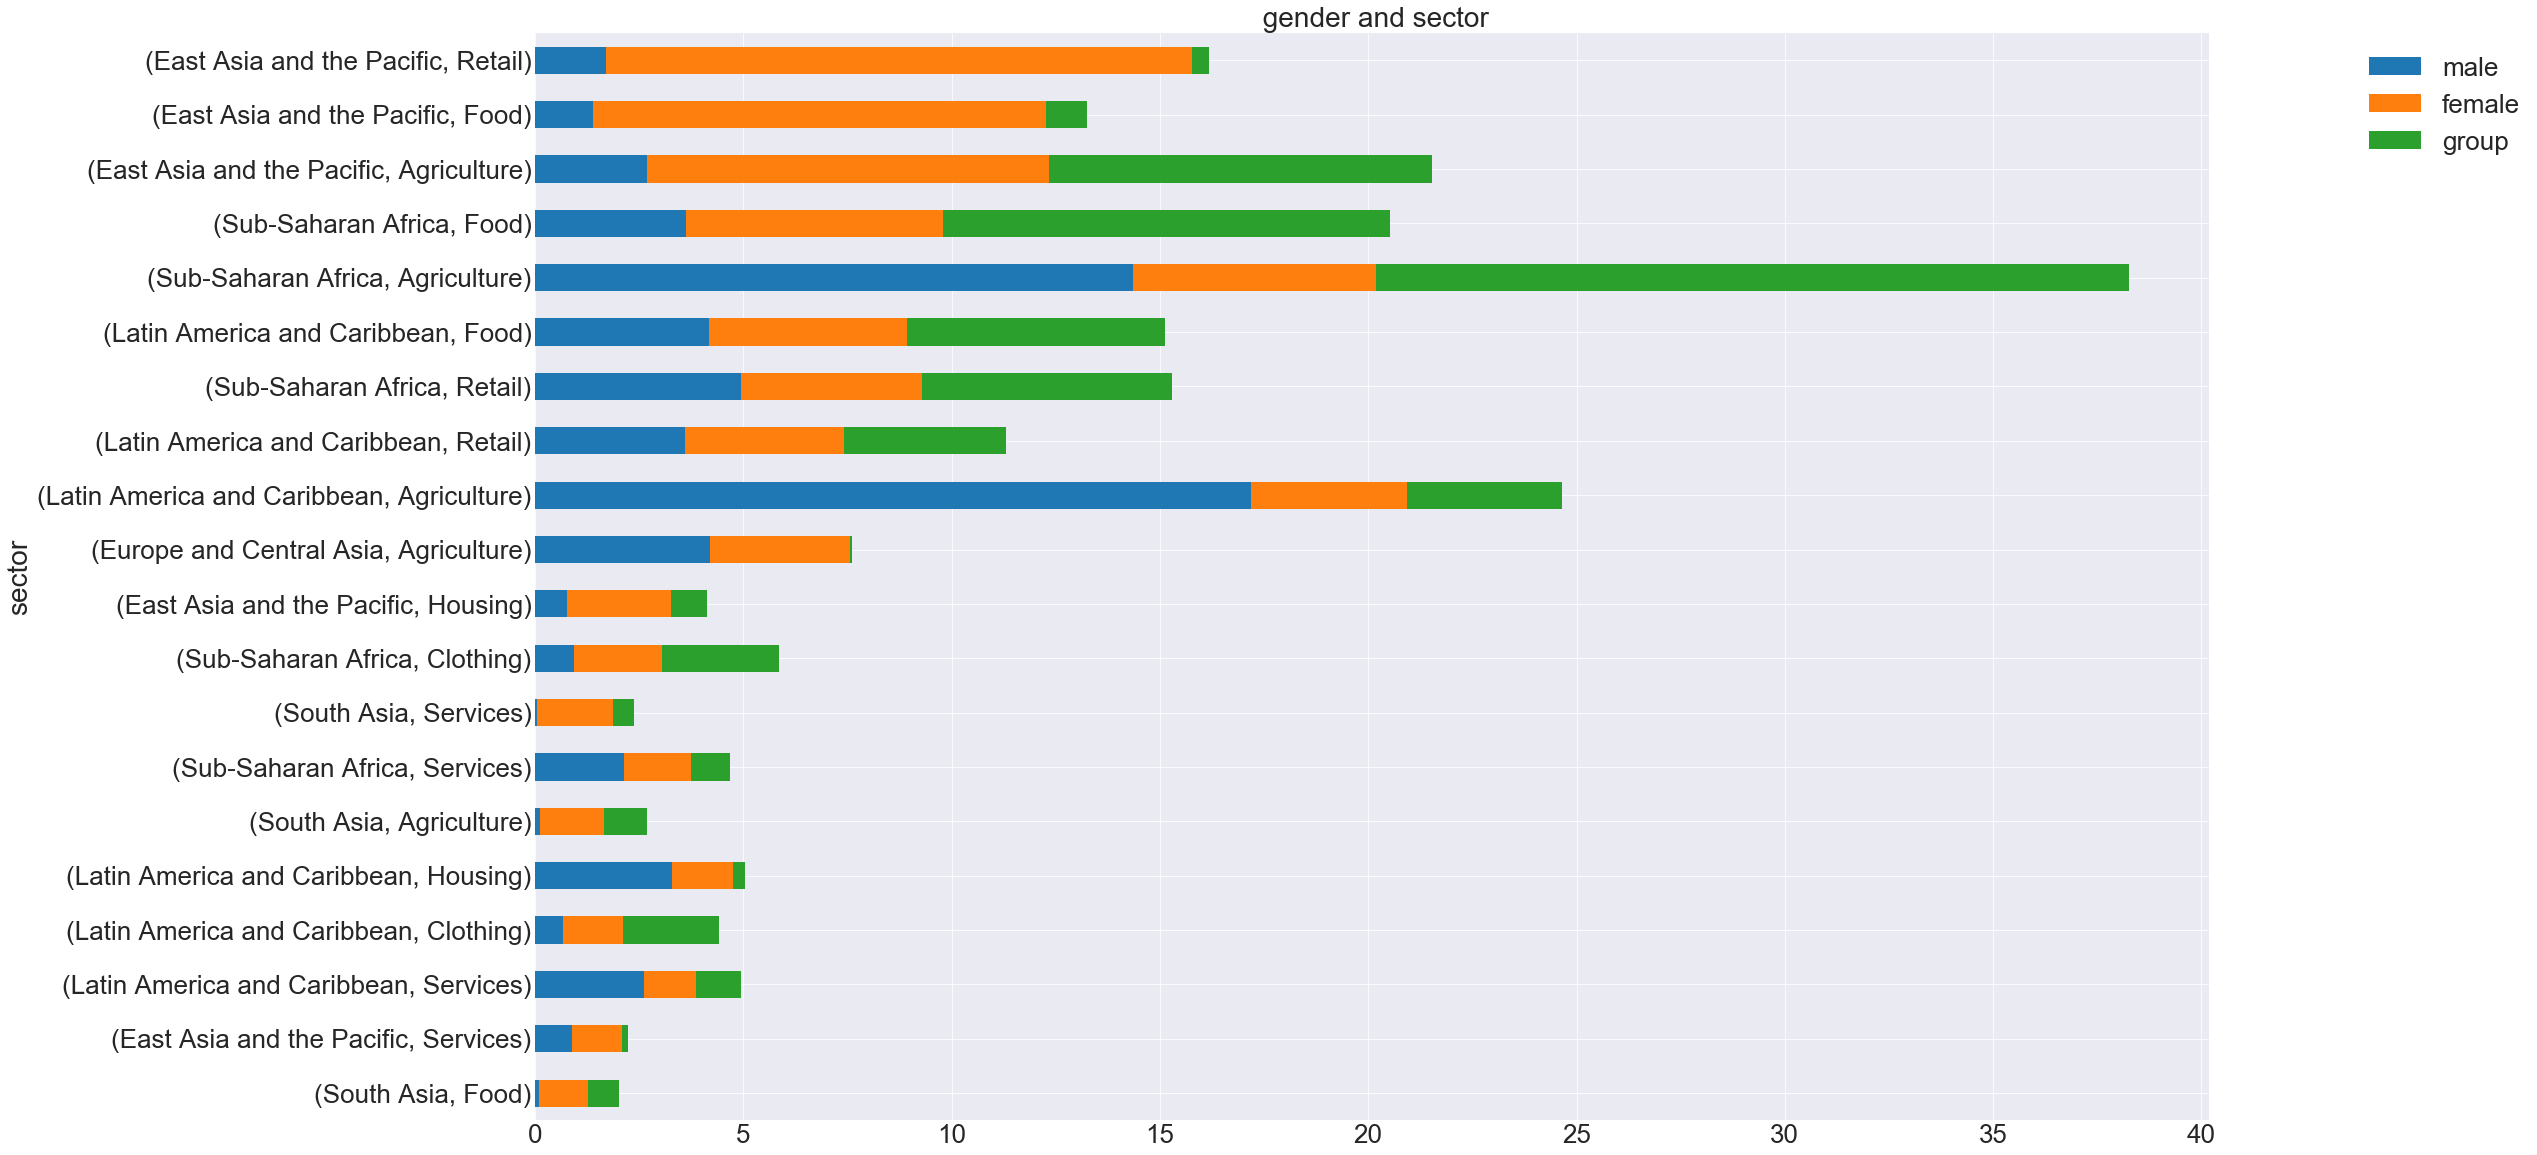

In [17]:
plot = dtf_dpnd.plot.barh(figsize = (30,20), fontsize = 26, stacked = True, title =' gender')
plot.title.set_size(28)
plot.legend(loc =1, bbox_to_anchor = (1.2,1), fontsize =26)
plt.ylabel ('sector',fontsize = 28)
plt.show()

1) В Юго-восточной Азии и Океании преимущественно женщины берут кредиты независимо от отрасли. 2) В Центральной и Южной Африке преобладают мужчины в сфере сельского хозяйства, в остальных отраслях большой разницы между мужчинами и женщинами нет, однако намного большая доля групповых займов по сравнению с другими регионами, то же можно сказать про Латинскую Америку, однако там количество мужских займов больше в сфере услуг и домохозяйства и групповые займы не так распространены.3) В Европе и Центральной Азии преобладают индивидуальные кредиты. 

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

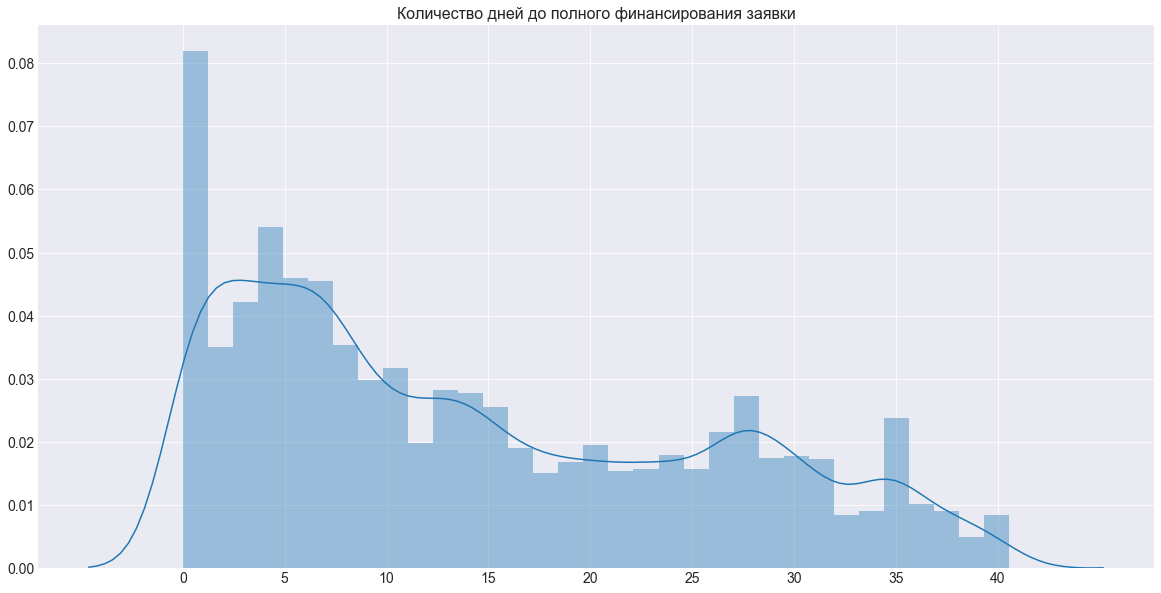

In [8]:

dev = (df_kiva_loans['loan_amount'] - df_kiva_loans['loan_amount'].mean()).abs()
std = df_kiva_loans['loan_amount'].std()
df_kiva1 = df_kiva_loans[~(dev> 3*std)]

df_loans_dates = df_kiva1.dropna(subset=['disbursed_time', 'funded_time'], how='any', inplace=False)

# dates columns:
dates = ['posted_time','disbursed_time']

# format dates:
df_loans_dates[dates] = df_loans_dates[dates].applymap(lambda x : x.split('+')[0])
df_loans_dates[dates] = df_loans_dates[dates].apply(pd.to_datetime)

# calculate time interval
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['disbursed_time']-df_loans_dates['posted_time']
df_loans_dates.loc[:, 'time_funding'] = df_loans_dates['time_funding'] / timedelta(days=1) 

# remove outliers +-3 sigma
dev = (df_loans_dates['time_funding']-df_loans_dates['time_funding'].mean()).abs()
std = df_loans_dates['time_funding'].std()
# Keep rows where time_funding interval > 0 only
df_loans_dates_trimmed = df_loans_dates[~(dev>3*std) & (df_loans_dates.loc[:, 'time_funding']>0)]

plt.figure(figsize=(20,10))
plt.title("Количество дней до полного финансирования заявки", fontsize=16)
plt.xticks(np.arange(0, max(df_loans_dates_trimmed['time_funding']+1), 5))
plt.tick_params(labelsize=14)

sns.distplot(df_loans_dates_trimmed['time_funding']).set(ylabel=None, xlabel=None)
plt.show()

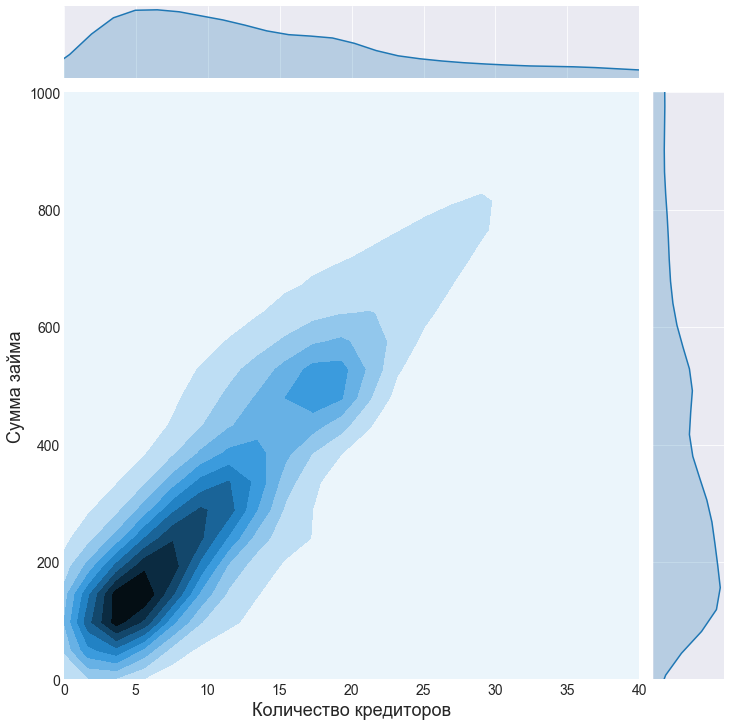

In [9]:
p = sns.jointplot(x="lender_count", y="loan_amount", data=df_loans_dates_trimmed, kind='kde', height=10, ratio=7, xlim=[0,40] , ylim=[0,1000])\
        .set_axis_labels("Количество кредиторов", "Сумма займа", size=18)


p.ax_joint.tick_params(labelsize=14)

plt.show()

Наиболее распространены группы заемщиков из 4-7 человек, берущих мелкие займы, до 200 долларов. С увеличением суммы займа, увеличивается и количество кредиторов

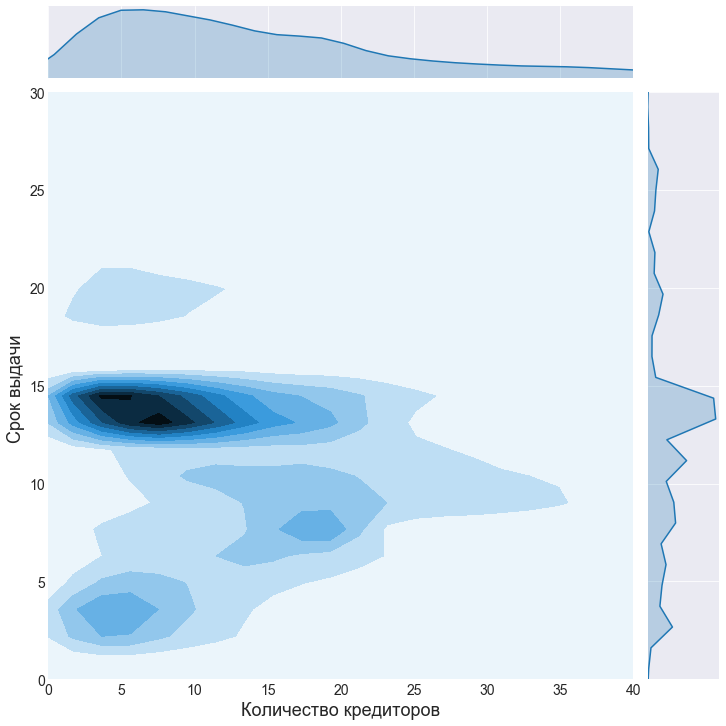

In [11]:
p = sns.jointplot(x="lender_count", y="term_in_months", data=df_loans_dates_trimmed, kind='kde', height=10, ratio=7, xlim=[0,40] , ylim=[0,30])\
        .set_axis_labels("Количество кредиторов", "Срок выдачи ", size=18)


p.ax_joint.tick_params(labelsize=14)

plt.show()

Преимущественно кредиты выдаются на 12-15 дней независимо от количества кредиторов, однако среди малеленьких групп кредиторов(4-7) человек также много кредитов со сроком выдачи до 5 дней и в меньшей стеепени кредитов сроком 20 дней.Также среди групп 15-20 человек распространены займы со сроком выдачи 5-10 дней.

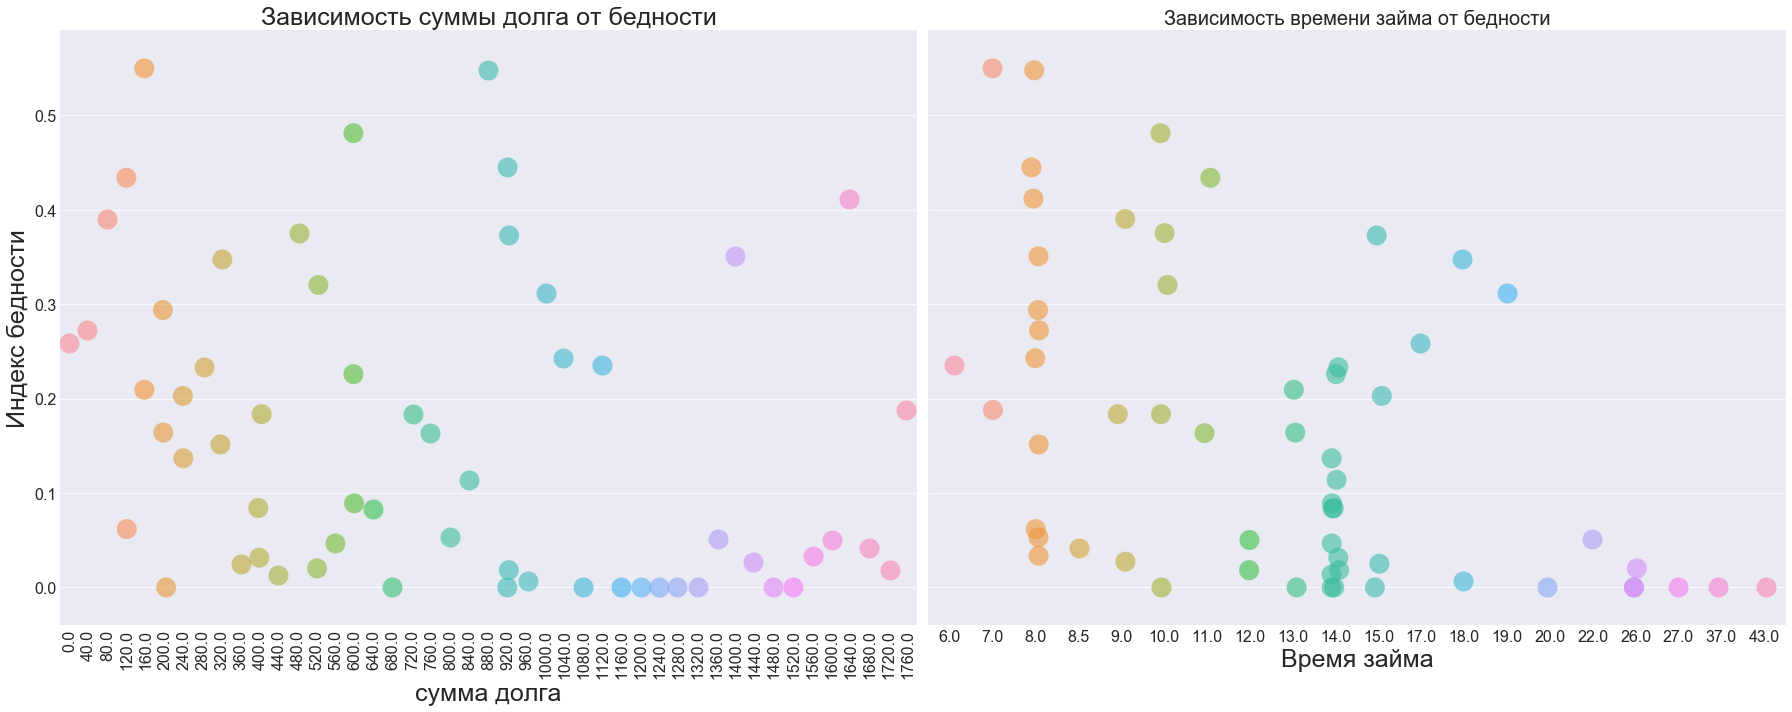

In [86]:
df_kiva2 = df_kiva1.groupby(['world_region', 'country'])\
    .agg({'loan_amount' : 'median', 'MPI' : 'median', 'term_in_months' : 'median'})\
    .reset_index()


f,ax=plt.subplots(1, 2, sharey=True, figsize=(25,10))

sns.stripplot(y='MPI', x='loan_amount', data=df_kiva2, alpha=0.6,size=20, ax=ax[0])
ax[0].set_title("Зависимость суммы долга от бедности", fontsize=25)
ax[0].set_xlabel('сумма долга', fontsize=25)
ax[0].set_xticklabels(np.arange(0, max(df_kiva2['loan_amount']+1), 40), rotation = 90)
ax[0].set_ylabel('Индекс бедности', fontsize = 25)
ax[0].tick_params(labelsize=16)

sns.stripplot(y='MPI', x='term_in_months', data=df_kiva2 , alpha=0.6, size =20,  ax=ax[1])
ax[1].set_title("Зависимость времени займа от бедности", fontsize=20)
ax[1].set_xlabel('Время займа', fontsize=25)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

В странах с более низким уровнем бедности гораздо больше крупных и более продолжительных займов, тогда когда в бедных странах преобладают мелкие, краткосрочные займы.

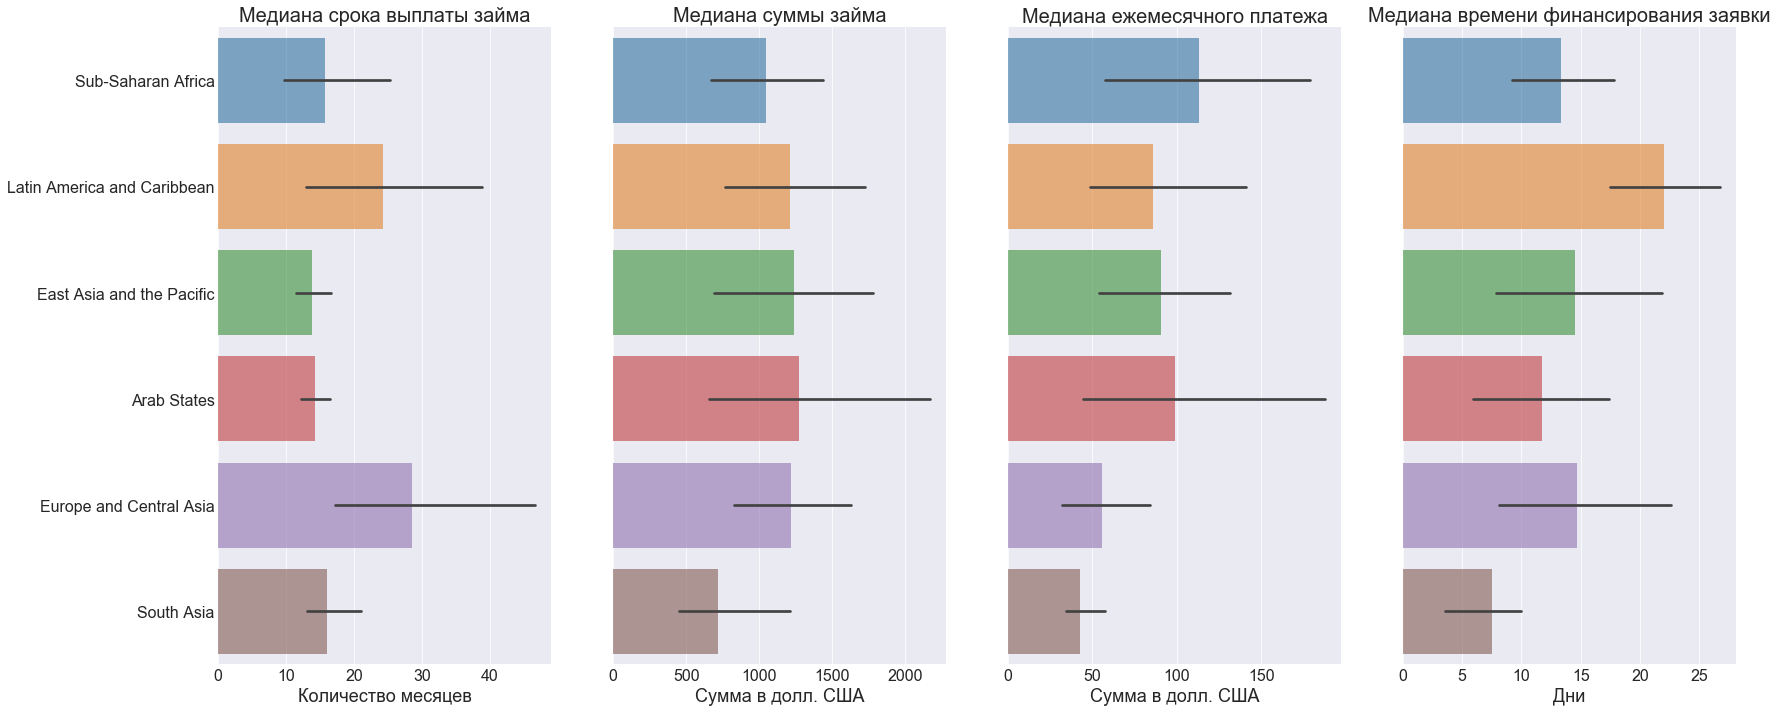

In [13]:
df_country_median = df_loans_dates_trimmed.groupby(['world_region', 'country'])\
    .agg({'loan_amount' : 'median', 'time_funding' : 'median', 'term_in_months' : 'median'})\
    .reset_index()

df_country_median = df_country_median.sort_values(by='term_in_months')

df_country_median['monthly_repayment'] = df_country_median['loan_amount'] / df_country_median['term_in_months']

f,ax=plt.subplots(1, 4, sharey=True, figsize=(25,10))

sns.barplot(y='world_region', x='term_in_months', data=df_country_median, alpha=0.6, ax=ax[0])
ax[0].set_title("Медиана срока выплаты займа", fontsize=20)
ax[0].set_xlabel('Количество месяцев', fontsize=18)
ax[0].set_ylabel(None)
ax[0].tick_params(labelsize=16)

sns.barplot(y='world_region', x='loan_amount', data=df_country_median, alpha=0.6, ax=ax[1])
ax[1].set_title("Медиана суммы займа", fontsize=20)
ax[1].set_xlabel('Сумма в долл. США', fontsize=18)
ax[1].set_ylabel(None)
ax[1].tick_params(labelsize=16)

sns.barplot(y='world_region', x='monthly_repayment', data=df_country_median, alpha=0.6, ax=ax[2])
ax[2].set_title("Медиана ежемесячного платежа", fontsize=20)
ax[2].set_xlabel('Сумма в долл. США', fontsize=18)
ax[2].set_ylabel(None)
ax[2].tick_params(labelsize=16)

sns.barplot(y='world_region', x='time_funding', data=df_country_median, alpha=0.6, ax=ax[3])
ax[3].set_title("Медиана времени финансирования заявки", fontsize=20)
ax[3].set_xlabel('Дни', fontsize=18)
ax[3].set_ylabel(None)
ax[3].tick_params(labelsize=16)

plt.tight_layout()
plt.show()

1) Долгосрочные займы более распространены в странах Европы и Центральной Азии, в меньшей степени в Латинской Америке, однако там самые долгие сроки финансирования заявки.  2) В Центральной и Южной Африке в среднем самые крупные ежемесячные платежи, что, возможно, связано с большим количеством групповых займов.